# 基盤DS演習 第7回
　今回の演習の内容は以下の5つである。

　**DS7.0 | データセットの構築**

　**DS7.1 | アンサンブル学習 (ensemble learning) とは**

　**DS7.2 | バギング (bagging)**

　**DS7.3 | ランダムフォレスト (random forest; RF)**

　**DS7.4 | ブースティング (boosting)**


## DS7.0 | データセットの構築

　今回も、手書き文字認識 (digits) のデータセットを用いるので、データの準備から始めよう。

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt

d = datasets.load_digits()
images = d.images

　以下のセルは、digitsのデータセットの画像を表示してくれる。 `image_index` が画像の番号を表すので、いくつかの画像を目で見ておくと良い。

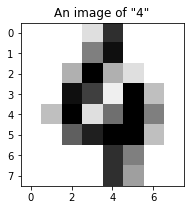

In [2]:
# display digit image
# change image_index and see each image with its label

image_index = 100
plt.figure(1, figsize=(3, 3))
plt.imshow(images[image_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("An image of \""+str(d.target[image_index])+"\"")
plt.show()

　今回も汎化性能を見るために訓練データとテストデータに分割し、訓練データのみから学習を行い、テストデータを予測することでモデルを評価していく。

In [3]:
# make training/test dataset
n_train = 1000
X_train = d.data[:n_train,:]
y_train = d.target[:n_train] # training data 
X_test = d.data[n_train:,:]
y_test = d.target[n_train:] # test data

images_train = images[:n_train]
images_test = images[n_train:]

## DS7.1 | アンサンブル学習とは

　**アンサンブル学習**とは、一つ一つの予測性能は高くない学習器を複数学習し、それらを多数決や平均などで集約した結果を出力することで、個々の学習器よりも高い精度の予測を行う手法である。原理的にはどのような学習器でもアンサンブル学習を行うことができるが、今回は決定木を使用する。

　まずは基盤データサイエンス 第3回に学んだ決定木について復習しよう。
決定木（decision tree）とは、目的変数（従属変数）をうまく分類できる説明変数で分岐させ続けることで分類を行うモデルである。



In [4]:
from sklearn import tree, metrics
single_tree = tree.DecisionTreeClassifier(max_depth=10, random_state=0)

single_tree.fit(X_train,y_train) # fitting 
y_pred = single_tree.predict(X_test) # prediction for test dataset

print(metrics.accuracy_score(y_pred, y_test)) # test accuracy

0.7791718946047679


　決定木単体では、テストデータに対して0.779という正解率であった。これが、アンサンブル学習によってどのようになっていくのか、見ていこう。

## DS7.2 | バギング (bagging)

　**バギング**とは複数の決定木の平均、もしくは多数決で予測を行う手法である。しかし、一般的には同じデータセットから学習を行うと同じ決定木が得られてしまう。当たり前であるが、同じモデルの平均や多数決では予測精度は向上しないので、異なるモデルを得る必要がある。

　一方、一つのデータセットを加工して複数の異なるデータセットを得ることができれば、そこから異なる決定木を学習することができる。この手法の一つに**ブートストラップ法 (bootstrap resampling)** がある。**バギングではブートストラップ法を用いて複数のデータセットを作成し、それぞれのデータセットに対して決定木を訓練する**ことで異なる決定木を得る。

　ブートストラップ法では、$N$ 個のデータを含むデータセットから**重複を許して（復元抽出で）**ランダムに$N$ 個を取り出し、新しいデータセットを作る。簡単なデータに対して実際にブートストラップ法を適用してみよう。

In [5]:
import numpy as np

data_orig = np.arange(10) # make a list of [0...9] 
print(data_orig)

[0 1 2 3 4 5 6 7 8 9]


In [6]:
data_sampled = np.random.choice(data_orig, len(data_orig)) # randomly choose from data_orig. do (len(data_orig)) times
print(data_sampled)

data_sampled = np.random.choice(data_orig, len(data_orig))
print(data_sampled)

[6 4 7 8 8 9 4 1 9 8]
[4 7 1 0 7 8 1 3 1 6]


　このように、ブートストラップ法を用いることにより、一つのデータセットから複数のデータセットを作成することができる。（これを使って、自分でバギングを実装するのは課題とする。）

　次に、scikit-learnを使ってバギングを実際に行ってみよう。scikit-learnでは`sklearn.ensenble`にアンサンブル学習の手法がまとめられている。scikit-learnのバギング(`BaggingClassifier`)では、`base_estimator`に指定したモデルを自動的に`n_estimator`個作成し、その多数決または平均で予測を行うことができる。

　`BaggingClassifier.fit()`を行うと、内部でブートストラップ法を用いて複数のデータセットが作成され、`n_estimator`個のモデルが一度に訓練されている。

In [7]:
from sklearn import ensemble
single_tree = tree.DecisionTreeClassifier(max_depth=10, random_state=0) 

bagging_dt = ensemble.BaggingClassifier(base_estimator=single_tree, n_estimators=10, random_state=0)
bagging_dt.fit(X_train,y_train) # fitting 

y_pred = bagging_dt.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test)) # test accuracy

0.877038895859473


　予測結果について、`image_index`の値を変更させながら、テストデータの画像とそのラベル、予測結果を同時に眺めてみよう。特に予測に失敗したデータを見つけると良い。

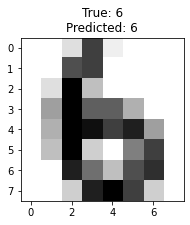

In [8]:
# display digit image
# change image_index and see each image with its label

image_index = 45
plt.figure(1, figsize=(3, 3))
plt.imshow(images_test[image_index], cmap=plt.cm.gray_r, interpolation='nearest')
title_str = "True: "+str(y_test[image_index]) + "\nPredicted: "+str(y_pred[image_index]) 
plt.title(title_str)
plt.show()

---

##### 課題 DS7.1

　sckit-learnを用いずにブートストラップ法によるデータセットの生成を実装してみよう。次のコードは以下の内容を実装するコードである。適切に `__xxxxx__`, `__yyyyy__`, `__zzzzz__` を埋めて実行可能にせよ。

1. 平均0, 標準偏差1の正規分布から1000個のデータをもつデータセット `data_normal` を作成する。

2. `data_normal` からブートストラップ法を用いて1000個のデータをもつデータセットを10回生成し、各データセットの平均と標準偏差を表示する。

なお、実行できるようになったら、平均と標準偏差が元の正規分布とほぼ同一であることを確認してほしい。


In [9]:
data_normal = np.random.normal(__xxxxx__)

num_iter = 10
for i in range(num_iter):
  data_sampled = np.random.choice(__yyyyy__, __zzzzz__)
  print(np.mean(data_sampled), np.std(data_sampled))


NameError: name '__xxxxx__' is not defined

---
##### 課題 DS7.2（発展、提出の必要はありません）

　scikit-learnの`BaggingClassifier`を使わずに、多数決によるバギングを実装してみよう。

　digitデータセットについて、学習するデータ数を1000としたとき、

1.   ブートストラップ法を用いて100個のデータセットを作成し、
2.   それぞれのデータセットに基づいて100個の決定木を`DecisionTreeClassifier`を用いて作成し、
3.   その結果の多数決をとる

ことによりバギングを実装せよ。また、その結果が`BaggingClassifier`を用いて実装したバギングの予測精度と概ね一致することを確認せよ。

-------


## DS7.3 | ランダムフォレスト (random forest)

　**ランダムフォレスト**はバギングを改良した手法であり、ブートストラップ法を用いて多数のデータセットを生成し、各データセットから決定木を生成する。それに加えて、ランダムフォレストでは**各決定木の分岐で使用する説明変数（特徴量）をランダムに一部だけ選んで使用**する。

　アンサンブル学習では各学習器の性質が多様であるほど集約の効果が高まるという性質がある。特徴量をランダムに選ぶことにより単独の学習器の性能が少し落ちる一方、学習器の多様性が高まるため、ランダムフォレストはバギングよりも性能が高いとされている。

　では、バギングと同様にランダムフォレストを学習させてみよう。

In [9]:
rf = ensemble.RandomForestClassifier(max_depth=10, n_estimators=10, random_state=0)
rf.fit(X_train,y_train) # fitting 

y_pred = rf.predict(X_test)

print(metrics.accuracy_score(y_pred, y_test)) # test accuracy


0.9071518193224593


　また、ランダムフォレストでは、各変数がどの程度予測に寄与しているかの情報を計算することができる。各決定木でそれぞれの分割を行う際、分割に使用した変数の寄与は分割に用いる指標の改善量で与えられる。これをすべての分割で合計することで各変数の寄与の割合が得られる。

　実際に上のランダムフォレストにおける各変数の寄与を見てみよう。

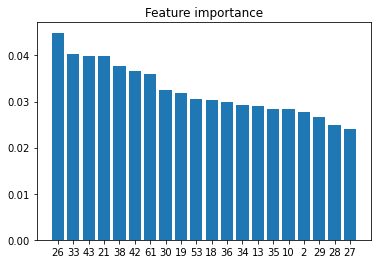

In [10]:
importances = rf.feature_importances_

# show importances as barplot
indices = np.argsort(importances)[::-1]
D = 20 # number of importances to show
plt.bar(range(D), importances[indices[:D]])
plt.xticks(range(D), indices[:D])
plt.title("Feature importance")
plt.show()

　重要な変数のIDが羅列されたが、これだけではイマイチ画像のどのあたりが重要かわからない。画像で表現してみよう。

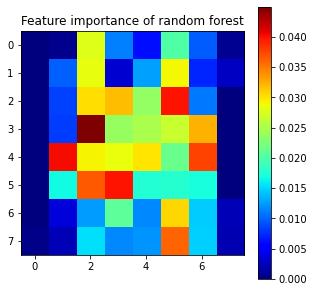

In [11]:
# show importances on image

importances_reshape = np.reshape(importances, images[0].shape)
fig, ax = plt.subplots(1, figsize=(5, 5))

im = plt.imshow(importances_reshape,
                interpolation='nearest', cmap=plt.cm.jet)
fig.colorbar(im)
plt.title("Feature importance of random forest")
plt.show()

　実際に文字が書かれている部分に寄与が集中しており、特に寄与が高いのは中央部であることがわかる。

　なお、ある特徴量の寄与が高いことは、その特徴量で木を分割した際にデータがきれいに分割できることを表しているだけで、その特徴量の値（画像であれば画素の値）が大きければ（小さければ）この文字は〇〇（数字 "3" とか）だと分類できる、というわけではないことに留意する必要がある。

---

##### 課題 DS7.3

　`ensemble.RandomForestClassifier()`に与えている変数`n_estimators`は多数決に使用する決定木の数を表すパラメータである。

　digitデータセットにおいて、`n_estimators`の値を20, 40, ...と増やしていったときに、テストデータの予測正解率はどのように変化していくだろうか。簡単に述べよ。

------


## DS7.4 | ブースティング (boosting)

　**ブースティング**はバギングやランダムフォレストと異なり、それぞれの決定木を同時に学習するのではなく、データの重みを変えながら順番に訓練していく手法である。今回の演習ではブースティングの代表的な手法である**Adaboost**を用いる。

　Adaboostでは、データの重みは過去に誤って予測したデータの重みが大きくなるようにし、最終的な予測はそれぞれの決定木の重み付き平均で行う。それぞれの決定木の重みは、その木を用いた際の訓練データへの予測精度が高いほど大きくなる。

　実際にAdaboostの学習を行ってみよう。

In [12]:
single_tree = tree.DecisionTreeClassifier(max_depth=10, random_state=0) 
ada_dt = ensemble.AdaBoostClassifier(base_estimator=single_tree, n_estimators=10, random_state=0)
ada_dt.fit(X_train,y_train) # fitting 

y_pred = ada_dt.predict(X_test)

print(metrics.accuracy_score(y_pred, y_test)) # test accuracy


0.9096612296110415


---
##### 課題 DS7.4
　バギング、ランダムフォレスト、AdaBoostそれぞれについて、木の数を10とした場合のテストデータの予測精度を比較し、性能の高い順に答えよ。

　また、木の数を1000とした場合についても同様に性能の高い順に答えよ。



---
##### 課題 DS7.5（発展）

　上記の例では、`ensemble.AdaBoostClassifier(base_estimator=single_tree, ...)`と、最大深さが10の決定木を使うことを明示的に指定したが、`base_estimator`を与えなかった場合はどのような学習器を用いてAdaboostを行うだろうか。
scikit-learnの[API Reference](https://scikit-learn.org/stable/modules/classes.html)を参照することで答えよ。

----

# レポート提出について



## レポートの提出方法
　レポートは**答案テンプレートを用い**、**1つのファイル（.doc, .docx, .pdf）**にまとめ、**学籍番号と氏名を確認の上**、**1週間後の16:20までに東工大ポータルのOCW-iから提出**すること。
ファイルのアップロード後、OCW-iで「提出済」というアイコンが表示されていることを必ず確認すること。それ以外の場合は未提出扱いとなるので十分注意すること。
また、締め切りを過ぎるとファイルの提出ができないため、時間に余裕を持って提出を行うこと。

## 答案テンプレート

```
学籍番号:
名前:

課題 DS7.1
__xxxxx__ = __________
__yyyyy__ = __________
__zzzzz__ = __________

課題 DS7.3
（自由記述）

課題 DS7.4
木の数が10本の時の予測精度： ________ > ________ > ________
木の数が1000本の時の予測精度： ________ > ________ > ________

課題 DS7.5
base_estimatorを指定しない場合は_________________が用いられる。


```

